In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import joblib

In [32]:
# AS I was having issues in downloading the databse ,I Used Kaggle also it supported me for faster fine tunning

In [33]:
df = pd.read_csv("/kaggle/input/housedata/data.csv")
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [34]:
df.info

<bound method DataFrame.info of                      date         price  bedrooms  bathrooms  sqft_living  \
0     2014-05-02 00:00:00  3.130000e+05       3.0       1.50         1340   
1     2014-05-02 00:00:00  2.384000e+06       5.0       2.50         3650   
2     2014-05-02 00:00:00  3.420000e+05       3.0       2.00         1930   
3     2014-05-02 00:00:00  4.200000e+05       3.0       2.25         2000   
4     2014-05-02 00:00:00  5.500000e+05       4.0       2.50         1940   
...                   ...           ...       ...        ...          ...   
4595  2014-07-09 00:00:00  3.081667e+05       3.0       1.75         1510   
4596  2014-07-09 00:00:00  5.343333e+05       3.0       2.50         1460   
4597  2014-07-09 00:00:00  4.169042e+05       3.0       2.50         3010   
4598  2014-07-10 00:00:00  2.034000e+05       4.0       2.00         2090   
4599  2014-07-10 00:00:00  2.206000e+05       3.0       2.50         1490   

      sqft_lot  floors  waterfront  view  c

### Data cleaning
#### Cheching for missing values

In [35]:
df.drop([ 'street', 'country', 'sqft_above', 'sqft_basement', 'sqft_lot'], axis=1, inplace=True)

In [36]:
df['renovated'] = (df['yr_renovated'] != 0).astype(int)
df['rooms'] = (df['bathrooms'] + df['bedrooms']).round(0).astype(int)
df['floors'] = df['floors'].round(0).astype(int)
df['price'] = df['price'].round(0).astype(int) 
df.head()
col_names = df.columns.tolist()
print(col_names)

['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'city', 'statezip', 'renovated', 'rooms']


In [37]:
nan_values = df.isna()

any_missing_values = nan_values.any().any()

any_missing_values_in_column = nan_values.any()

missing_value_count = df.isnull().sum()


for column, has_missing in any_missing_values_in_column.items():
    if has_missing:
        count = missing_value_count[column]
        print(f"-----> Column '{column}' has {count} missing values.")
        
print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)

print("\nMissing Values in Each Column?")
print(any_missing_values_in_column)

print("\nMissing Value Counts in Each Column:")
print(missing_value_count)


Missing Values in the Entire DataFrame?
False

Missing Values in Each Column?
date            False
price           False
bedrooms        False
bathrooms       False
sqft_living     False
floors          False
waterfront      False
view            False
condition       False
yr_built        False
yr_renovated    False
city            False
statezip        False
renovated       False
rooms           False
dtype: bool

Missing Value Counts in Each Column:
date            0
price           0
bedrooms        0
bathrooms       0
sqft_living     0
floors          0
waterfront      0
view            0
condition       0
yr_built        0
yr_renovated    0
city            0
statezip        0
renovated       0
rooms           0
dtype: int64


### Data visualization

Text(0.5, 1.0, 'Houses which have waterfront')

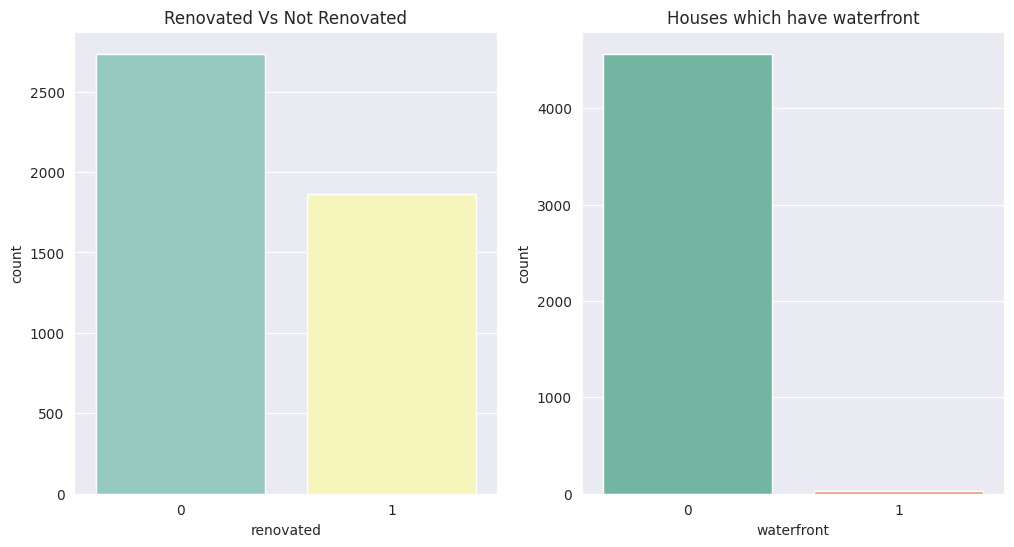

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2 , 1)
sns.countplot(x='renovated', data=df, palette='Set3')
plt.title('Renovated Vs Not Renovated')

plt.subplot(1, 2 , 2)
sns.countplot(x='waterfront', data=df, palette='Set2')
plt.title('Houses which have waterfront')

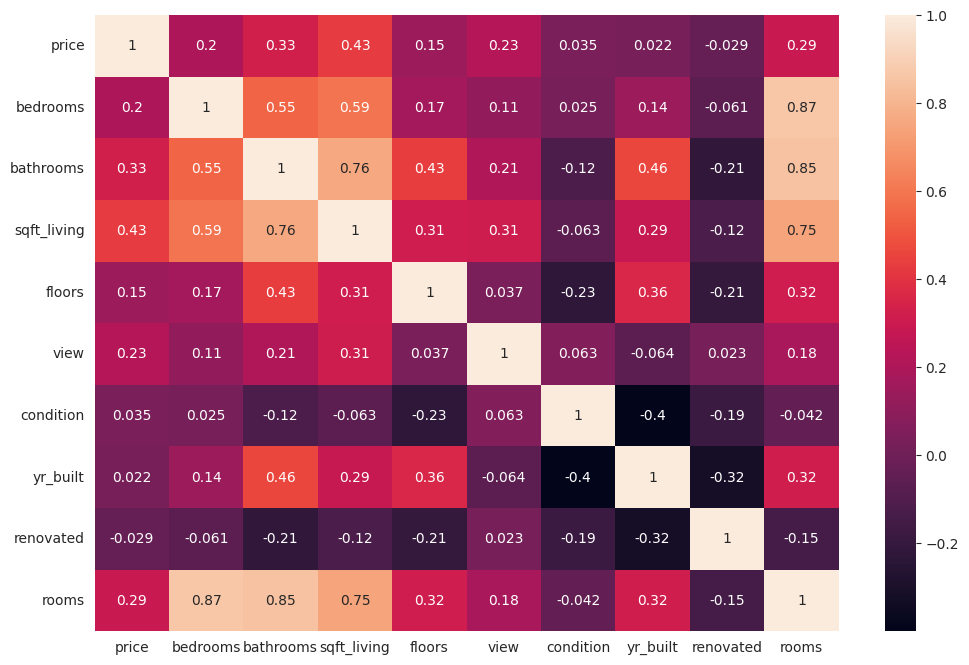

In [39]:
df_corr = df.drop(['city', 'yr_renovated', 'statezip', 'date', 'waterfront'], axis=1)
matrix_corr = df_corr.corr()
figure = plt.figure(figsize=(12, 8))
sns.heatmap(matrix_corr, annot=True)
plt.show()

In [40]:
df = df.drop(['waterfront'], axis=1)

In [41]:
def apply_filter_to_column(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    threshold_multiplier = 3.0
    
    lower_bound = Q1 - threshold_multiplier * IQR
    upper_bound = Q3 + threshold_multiplier * IQR

    filtered_column = df[column].apply(lambda x: x if (x >= lower_bound) and (x <= upper_bound) else None)
    return filtered_column

data_to_filter = ['price', 'sqft_living', 'floors', 'view', 'condition', 'yr_built']


df_copy = df.copy()

for column in data_to_filter:
    filtered_column = apply_filter_to_column(column)
    df_copy[f'{column}_filtered'] = filtered_column


df_copy = df_copy.dropna(how='all', subset=[f'{column}_filtered' for column in data_to_filter])

filtered_columns = df_copy.columns.tolist()

print(filtered_columns)

['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'condition', 'yr_built', 'yr_renovated', 'city', 'statezip', 'renovated', 'rooms', 'price_filtered', 'sqft_living_filtered', 'floors_filtered', 'view_filtered', 'condition_filtered', 'yr_built_filtered']


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

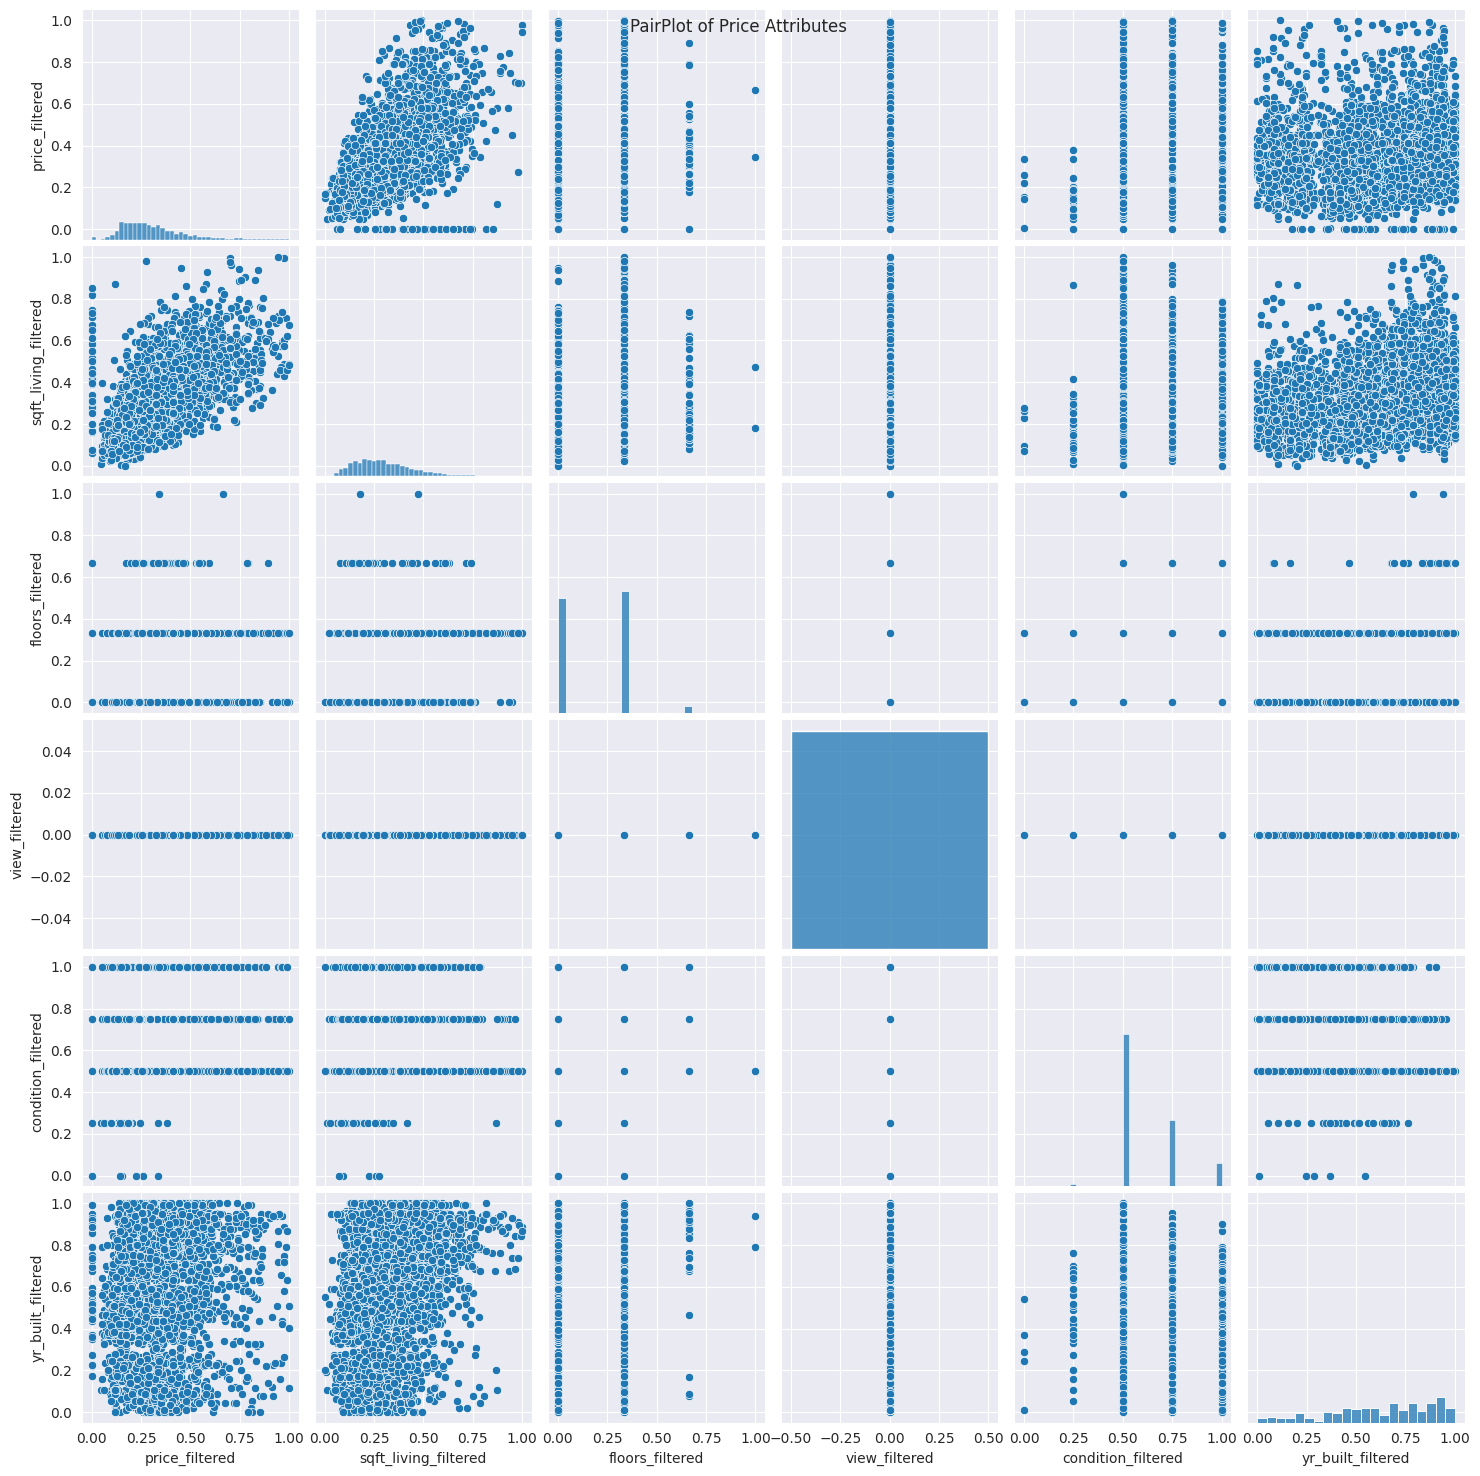

In [42]:

data_to_plot = ['price_filtered', 'sqft_living_filtered', 'floors_filtered', 'view_filtered', 'condition_filtered', 'yr_built_filtered']
if df_copy is not None and not df_copy.empty:
    scaler = MinMaxScaler()
    df_copy = scaler.fit_transform(df_copy[data_to_plot])
    df_copy = pd.DataFrame(df_copy, columns=data_to_plot)
    plt.figure(figsize=(6, 6))
    sns.pairplot(df_copy)
    plt.suptitle('PairPlot of Price Attributes')
    plt.show()
else:
    print("Filtered data is empty or None. Check your ebalo")

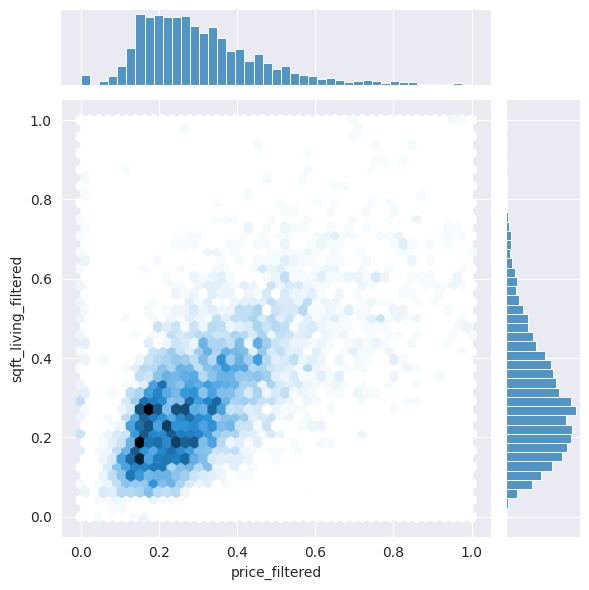

In [43]:
sns.jointplot(data=df_copy, x='price_filtered', y='sqft_living_filtered', kind = "hex", dropna=True)


### Preparation data and creating the model

In [48]:
df_x = df_copy['sqft_living_filtered'].to_numpy()
df_y = df_copy['price_filtered'].to_numpy()

indexes_to_remove = np.where(df_y == 0)[0]
df_y = np.delete(df_y, indexes_to_remove)
df_x = np.delete(df_x, indexes_to_remove)

df_copy.dropna(subset=['price_filtered', 'sqft_living_filtered'], inplace=True)
if df_copy[['price_filtered', 'sqft_living_filtered']].isna().any().any():
    print("There are still NaN values in the data.")
else:
    print("No NaN values found, proceed with model training.")

No NaN values found, proceed with model training.


In [45]:
#print("Number of NaN values in 'price_filtered':", df_copy['price_filtered'].isna().sum())
#print("Number of NaN values in 'sqft_living_filtered':", df_copy['sqft_living_filtered'].isna().sum())

In [49]:
df_x = df_x.reshape(-1, 1)
dx_y = df_y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (3567, 1)
y_train shape: (3567,)


In [50]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [51]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.014384921907884709
R-squared: 0.4793920505088386


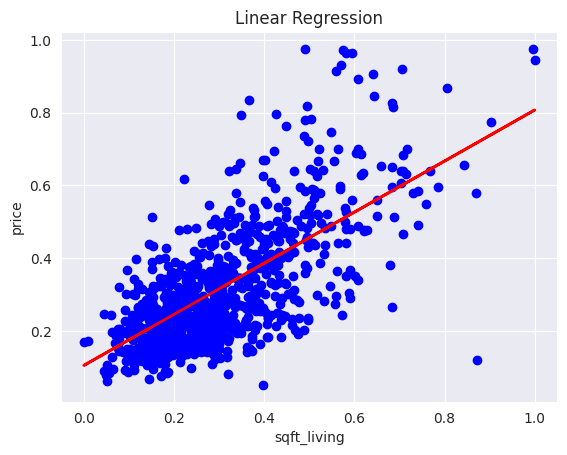

In [52]:
plt.scatter(x_test, y_test, color='blue')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Linear Regression')
plt.show()

In [53]:
joblib.dump(model, 'linear_regression.pkl')

['linear_regression.pkl']

In [54]:
model = joblib.load('linear_regression.pkl')
data_test = pd.DataFrame({'sqft_living': [0.6, 0.2, 1]})
predictions = model.predict(data_test)
print(predictions)

[0.52625086 0.24523076 0.80727095]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
